In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# IO utils


# Data

In [3]:
# palm_file = './temp/2024-03-04_08-17-49.emg8'
palm_file = './temp/2024-03-04_11-11-02.emg8'
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='warn')
gestures = gestures[~gestures['state'].isin(['Baseline', 'Finish'])]
gestures.sort_index(inplace=True)
gestures.reset_index(drop=True, inplace=True)

print(gestures.shape)
gestures.head()

(2545, 56)


,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,134045.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,...,2974.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.02
1,134078.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2933.0,2931.0,...,2975.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.05
2,134111.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,...,2975.0,2975.0,2975.0,2974.0,2978.0,2969.0,1,Neutral,0,5.08
3,134144.0,33.0,2931.0,2943.0,2932.0,2920.0,2933.0,2935.0,2934.0,2932.0,...,2974.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.12
4,134177.0,33.0,2931.0,2943.0,2932.0,2920.0,2934.0,2934.0,2934.0,2931.0,...,2975.0,2975.0,2975.0,2973.0,2978.0,2969.0,1,Neutral,0,5.15


In [4]:
OMG_CH = np.arange(50).astype(str)

In [5]:
# [X features] '0', ..., '49' - каналы OMG датчиков
# 'ts' - метка времени
gestures.columns

Index(['ts', 'td', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', 'prot', 'state', 'id', 'now'],
      dtype='object')

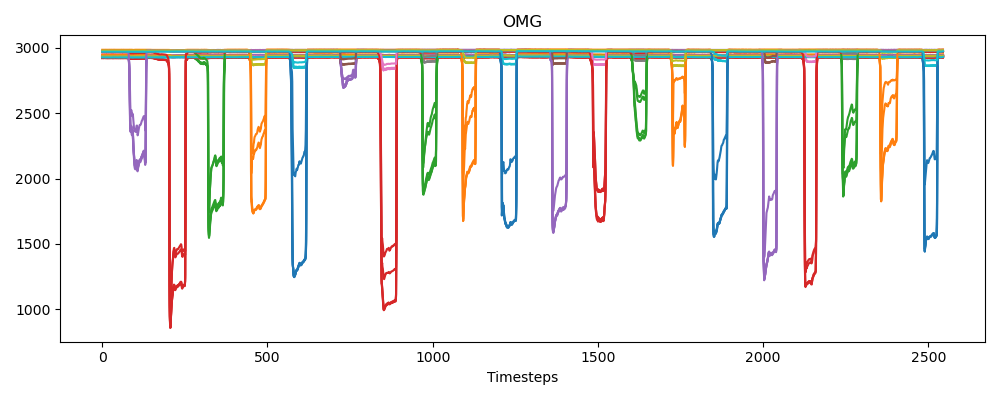

In [6]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [7]:
X = gestures[OMG_CH].values

le = LabelEncoder()
state = gestures['state'].values
y_cmd = le.fit_transform(state)

display(np.c_[le.transform(le.classes_), le.classes_])

print(X.shape, y_cmd.shape)

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

(2545, 50) (2545,)


In [8]:
GESTURES = le.classes_
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

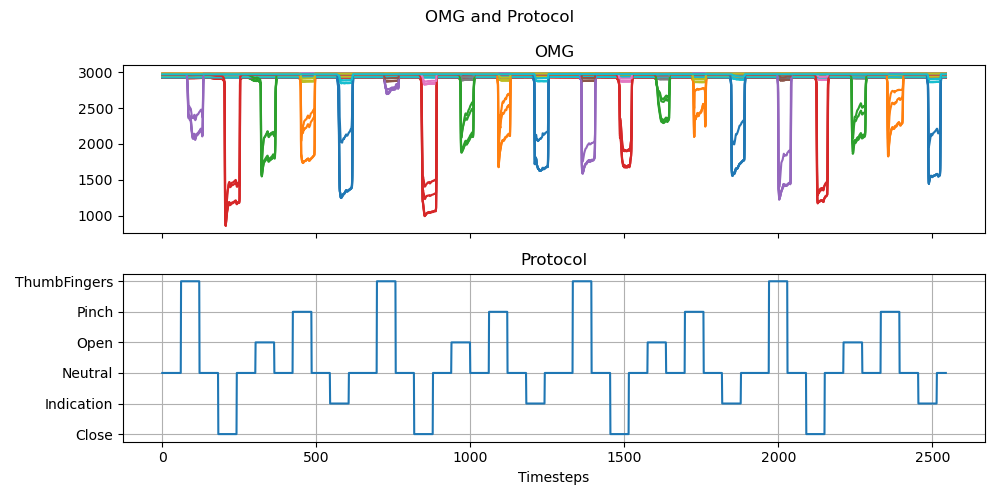

In [9]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Modeling

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X, y_cmd)
model.score(X, y_cmd)

/home/user/miniconda3/envs/tf214/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6974459724950884

# Real-time inference

In [11]:
import time
import serial
from IPython.display import clear_output

## Inference Utils: Put your code here

In [98]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict_proba([x])[0]
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

# def commands(x):
#     y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
#     return y

def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # 'Close'
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 1: # 'Indication'
        cmd.update({'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 2: # 'Neutral'
        pass
        return cmd
    elif x == 3: # 'Open'
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 4: # 'Pinch'
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 5: # 'ThumbFingers'
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    else:
        return cmd

In [99]:
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

## Inference

### Offline (dataset)

In [100]:
df_sim = gestures.iloc[:, :52]
print(df_sim.shape)

(2545, 52)


In [101]:
df_sim

,ts,td,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,134045.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,...,2973.0,2984.0,2974.0,2963.0,2974.0,2975.0,2975.0,2973.0,2978.0,2969.0
1,134078.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2933.0,2931.0,...,2973.0,2984.0,2974.0,2963.0,2975.0,2975.0,2975.0,2973.0,2978.0,2969.0
2,134111.0,33.0,2931.0,2943.0,2932.0,2921.0,2933.0,2934.0,2934.0,2931.0,...,2973.0,2984.0,2974.0,2963.0,2975.0,2975.0,2975.0,2974.0,2978.0,2969.0
3,134144.0,33.0,2931.0,2943.0,2932.0,2920.0,2933.0,2935.0,2934.0,2932.0,...,2973.0,2984.0,2974.0,2963.0,2974.0,2975.0,2975.0,2973.0,2978.0,2969.0
4,134177.0,33.0,2931.0,2943.0,2932.0,2920.0,2934.0,2934.0,2934.0,2931.0,...,2973.0,2984.0,2974.0,2963.0,2975.0,2975.0,2975.0,2973.0,2978.0,2969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,217865.0,33.0,2932.0,2946.0,2936.0,2924.0,2943.0,2937.0,2937.0,2934.0,...,2972.0,2986.0,2977.0,2966.0,2984.0,2977.0,2978.0,2975.0,2980.0,2970.0
2541,217898.0,33.0,2932.0,2946.0,2936.0,2925.0,2942.0,2937.0,2937.0,2934.0,...,2973.0,2986.0,2977.0,2967.0,2984.0,2978.0,2978.0,2975.0,2980.0,2970.0
2542,217931.0,33.0,2933.0,2946.0,2936.0,2925.0,2943.0,2937.0,2937.0,2934.0,...,2973.0,2987.0,2977.0,2967.0,2983.0,2978.0,2978.0,2975.0,2980.0,2971.0
2543,217964.0,33.0,2933.0,2946.0,2936.0,2925.0,2943.0,2938.0,2937.0,2934.0,...,2973.0,2987.0,2977.0,2967.0,2983.0,2977.0,2978.0,2975.0,2981.0,2972.0


In [103]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed.argmax())
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=52, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed)
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [104]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (2545, 50)
sample_preprocessed.shape = (2545, 50)
y_predicted.shape = (2545, 6)
y_postprocessed.shape = (2545, 6)
y_commands.shape = (2545,)


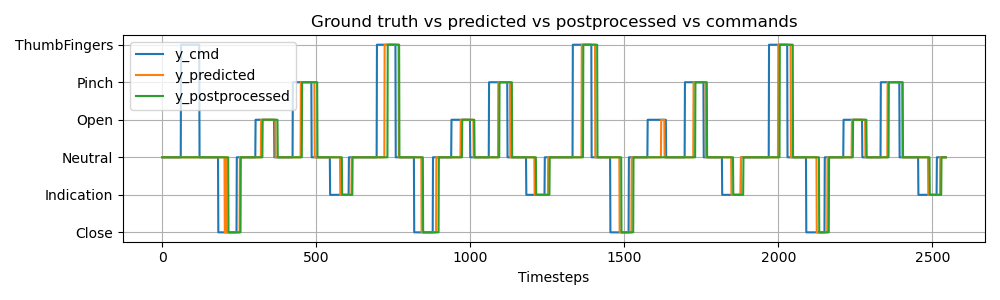

In [105]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_cmd, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'].argmax(axis=1), c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'].argmax(axis=1), c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_cmd, y_dct['y_postprocessed'].argmax(axis=1), target_names=GESTURES))

              precision    recall  f1-score   support

       Close       0.62      0.42      0.50       241
  Indication       0.66      0.40      0.50       242
     Neutral       0.60      0.81      0.69      1334
        Open       0.71      0.39      0.50       243
       Pinch       0.68      0.49      0.57       243
ThumbFingers       0.61      0.32      0.42       242

    accuracy                           0.62      2545
   macro avg       0.65      0.47      0.53      2545
weighted avg       0.63      0.62      0.60      2545



### Online (prosthesis or virtual hand)

In [108]:
from copy import deepcopy
import MotoricaInterface as mi; assert(mi.__version__=="0.0.3") # last time tested
vp = mi.VirtualPhantomClient('localhost', 1755)

In [109]:
!ls /dev/ttyUSB*

/bin/bash: /home/user/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/dev/ttyUSB1


In [21]:
TIMEOUT = 0.033
DEBUG = True

ser = None
ser_port = None
ser_port = '/dev/ttyUSB1'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, baudrate=115200, timeout=1.0)
    # time.sleep(0.2)

    # ser.write('M0\r\n'.encode())
    # time.sleep(0.1)

    # # ser.write('S2\r\n'.encode())
    # # time.sleep(0.1)

    # ser.write('PT\r\n'.encode())
    # time.sleep(0.1)
    # ser.write('Pt\r\n'.encode())
    # time.sleep(0.1)
    # ser.flush()

    # time.sleep(0.1)

In [22]:
def parseline():
    line = ser.readline().decode().replace('\n', '')
    data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
    return data

ser.readline()
while True:
    data = parseline()
    print(f"data len: {len(data)} |", list(data), end = '                                          \r')

KeyboardInterrupt: 

In [112]:
# flush buffers
ser.reset_input_buffer()
ser.read()

i = 0;
while(ser.in_waiting):
    print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
    ser.read_all()
    time.sleep(0.005)
    i+=1;
ser.readline()
ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None

pack = None

prev_state = 'None'
prev_idx = -1
y_commands = vp.neutral_state.copy()

while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = s.decode().replace('\n', '')
        data = np.array(list(filter(len, np.array(sample.split(" "))))).astype(float)
        [[ts, cycle_ts], omg_sample] = np.array_split(data, [2])
        
    except Exception as e:
        print(e)
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed.argmax())
    # [/Commands composition]
    
    # [Commands sending]
    # pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    prot_idx = deepcopy(y_commands)
    if (prot_idx!=prev_idx):
        # socket_send(row.Command)
        vp.send_cmd(**y_commands)
        prev_idx = prot_idx
    # [/Commands sending]
    
    y_previous = y_postprocessed

    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed, GESTURES[y_postprocessed])
        # print(y_commands)
        # print(pack)
    
    ts_diff = time.time() - ts_start
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

KeyboardInterrupt: 

# Draft

In [ ]:
# crc_table = [
#     54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
#     111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
#     113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
#     179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
#     115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
#     88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
#     97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
#     45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
#     153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
#     114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
#     215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
#     0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
#     18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
#     57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
#     193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
#     213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
#     137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
#     67, 112, 109, 78, 114, 165, 244, 183, 121
# ];
    
# def get_crc(data, count):
#     result = 0x00
#     l = count
#     while (count>0):   
#         result = crc_table[result ^ data[l-count]]
#         count -= 1;
#     return result;

# def drv_abs_one(ser, control):
#     if ser is None:
#         return
#     pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
#     pack[-1] = get_crc(pack[1:], 9)
#     return (pack, ser.write(bytearray(pack)))